In [1]:
import numpy as np
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
K.set_image_dim_ordering('th')

from vgg16 import Vgg16
from matplotlib import pyplot as plt
%matplotlib inline

path = "datasets/"
batch_size=4

Using Theano backend.


# Simple CNN

In [2]:
from keras.models import Sequential  # simple linear feed forward network
from keras.layers import Dense, Dropout, Activation, Flatten  # core layer in neural network
from keras.layers import Convolution2D, MaxPooling2D  # Convolutional NN layers

In [3]:
def simpleCNN():
    model = Sequential()  # 1
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(1, 224, 224)))  # 2
    model.add(MaxPooling2D(pool_size=(2, 2)))  # 3
    model.add(Convolution2D(32, (3, 3), activation='relu'))  # 4
    model.add(MaxPooling2D(pool_size=(2, 2)))  # 5
    model.add(Convolution2D(32, (3, 3), activation='relu'))  # 6
    model.add(MaxPooling2D(pool_size=(2, 2)))  # 7
    model.add(Dropout(0.25))  # 8
    model.add(Flatten())  # 9
    model.add(Dense(128, activation='relu'))  # 10
    model.add(Dropout(0.5))  # 11
    model.add(Dense(2, activation='softmax'))  # 12
    model.summary()
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) # 13
    return model

1. declare a sequential feed forward neural network 
2. this add the first input layer into the sequential model. input_shape should match the shape of each image in our datasets, in this case, 3 channel and 224 by 224 pixels. (since the data is in grayscale, can see if 1 channel speed up the training / improve the accuracy)
3. maxpooling is a way to reduce number of parameters in our model. In this case, a 2 by 2 pooling filter is used. How it works is a 2x2 matrix will slide through the previous layer and obtain the max of the 4 values
4. add one more convolution layer
5. maxpooling again
6. yet another convolution layer
7. another maxpooling
8. a dropout is added to randomly drop out certain weight to prevent overfitting
9. flatten the output of the layers to 1 dimensional
10. then connect it with a fully-connected / dense layer.
11. apply dropout again
12. connect it with another dense layer with 2 outputs, which will be our prediction
13. Compile the model by declaring the loss function and optimizer we want to use. Keras has a lot of different loss function (https://keras.io/losses/) and optimizer (https://keras.io/optimizers/) that we can choose from. 

In [4]:
simple_cnn = simpleCNN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 222, 222)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 111, 111)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 109, 109)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 54, 54)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 52, 52)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 26, 26)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 26, 26)        0         
__________

In [5]:
gen = ImageDataGenerator()  # can put in data augmentation here, eg: rotation_range, width_shift_range, height_shift_range, shear_range, zoom_range, horizontal_flip, vertical_flip
batches = gen.flow_from_directory(path + 'train', target_size=(224,224), batch_size=batch_size, color_mode='grayscale')
val_batches = gen.flow_from_directory(path + 'valid', target_size=(224,224), batch_size=batch_size, color_mode='grayscale')
test_batches = gen.flow_from_directory(path + 'test',  target_size=(224,224), batch_size=batch_size, color_mode='grayscale')

Found 16 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 2 images belonging to 1 classes.


In [7]:
imgs, labels = next(batches)
imgs[0].shape

(1, 224, 224)

In [40]:
simple_cnn.fit_generator(batches, steps_per_epoch=batches.samples, epochs=5,
                validation_data=val_batches, validation_steps=val_batches.samples)

Epoch 1/5
16/16 [==============================] - 58s - loss: 10.0738 - acc: 0.3750 - val_loss: 9.8220 - val_acc: 0.3906
Epoch 2/5
16/16 [==============================] - 25s - loss: 10.0738 - acc: 0.3750 - val_loss: 9.8220 - val_acc: 0.3906
Epoch 3/5
16/16 [==============================] - 22s - loss: 9.8220 - acc: 0.3906 - val_loss: 9.8220 - val_acc: 0.3906
Epoch 4/5
16/16 [==============================] - 22s - loss: 9.8220 - acc: 0.3906 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 5/5
16/16 [==============================] - 24s - loss: 10.0738 - acc: 0.3750 - val_loss: 9.5701 - val_acc: 0.4062


In [41]:
imgs, labels = next(test_batches)

In [42]:
classes = list(iter(batches.class_indices))
for c in batches.class_indices:
    classes[batches.class_indices[c]] = c
classes

['gotcrystal', 'nocrystal']

In [43]:
all_predictions = simple_cnn.predict(imgs)
all_predictions

array([[ 1.,  0.],
       [ 1.,  0.]], dtype=float32)

In [44]:
idxs = np.argmax(all_predictions, axis=1)
predicted_class = [classes[idx] for idx in idxs]
predicted_class

['gotcrystal', 'gotcrystal']

Predicted class: gotcrystal


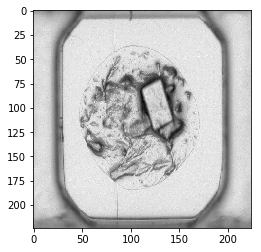

In [45]:
img = imgs[0].reshape((imgs[0].shape[1], imgs[0].shape[2]))
plt.imshow(img, cmap='gray')
print("Predicted class: {}".format(predicted_class[0]))

Predicted class: gotcrystal


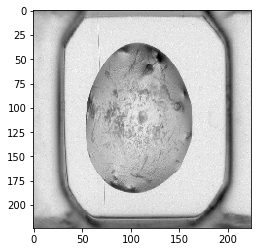

In [46]:
img = imgs[1].reshape((imgs[1].shape[1], imgs[1].shape[2]))
plt.imshow(img, cmap='gray')
print("Predicted class: {}".format(predicted_class[1]))

the simple CNN model achieve a training accuracy of 37.5% only, which is even worse random guess (50%). Most likely is due to:
1. lack of training data
2. trained only for 5 epochs

# VGG16 Network

As you can see, a simple CNN doesn't seems to work too well (reason mentioned above). Instead of retraining the network from scratch, we can use some state of the art network that has already trained with millions of images. Such network would have already learned features such as lines, curves and colors that are useful for most computer vision problems. Example of such networks are VGG, ResNet and Inception.

In [62]:
# load model with pre-trained weights, model code is provided by FastAI course
vgg = Vgg16()

# Grab a few images at a time for training and validation.
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)

# quick hack for keras 2.+
batches.nb_class = batches.num_class
batches.nb_sample = batches.samples
val_batches.nb_class = val_batches.num_class
val_batches.nb_sample = val_batches.samples

# finetuning model so that it output only number of classes based on how we structure the directory (in this case 2 which is gotcrystal / nocrystal)
vgg.finetune(batches)

# training the model and by running 5 epochs
vgg.fit(batches, val_batches, nb_epoch=5)

Found 16 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/5
16/16 [==============================] - 119s - loss: 0.7319 - acc: 0.7969 - val_loss: 0.0152 - val_acc: 1.0000
Epoch 2/5
16/16 [==============================] - 109s - loss: 0.0537 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 3/5
16/16 [==============================] - 107s - loss: 0.0086 - acc: 1.0000 - val_loss: 0.0082 - val_acc: 1.0000
Epoch 4/5
16/16 [==============================] - 106s - loss: 0.0305 - acc: 0.9844 - val_loss: 2.8517e-04 - val_acc: 1.0000
Epoch 5/5
16/16 [==============================] - 105s - loss: 0.0019 - acc: 1.0000 - val_loss: 2.6481e-04 - val_acc: 1.0000


do note that this is not the correct way in doing validation as we are using the same images for both training and validation (thus a validation accuracy of 100%). The model will "remember" the images instead of generalizing it well for unseen images

In [63]:
test_batches = vgg.get_batches(path+'test', batch_size=batch_size)

Found 2 images belonging to 1 classes.


In [64]:
imgs, labels = next(test_batches)

In [65]:
probability, predicted_index, predicted_class = vgg.predict(imgs)

## Visualizing prediction

Predicted class: nocrystal with probability of: 0.999996542931


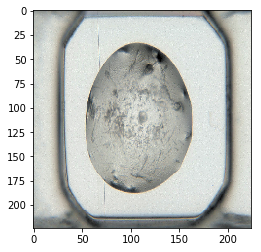

In [66]:
import numpy as np
img = np.rollaxis(imgs[0], 0, 3).astype(np.uint8)
plt.imshow(img)
print("Predicted class: {} with probability of: {}".format(predicted_class[0], probability[0]))

Predicted class: gotcrystal with probability of: 0.999919474125


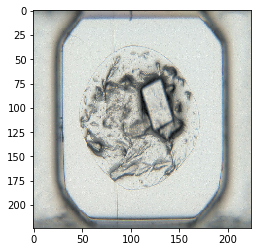

In [67]:
img = np.rollaxis(imgs[1], 0, 3).astype(np.uint8)
plt.imshow(img)
print("Predicted class: {} with probability of: {}".format(predicted_class[1], probability[1]))

In [68]:
vgg.model.save_weights('protein.h5')

# Generating augmented data

In [32]:
augmented_gen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)

Found 16 images belonging to 2 classes.


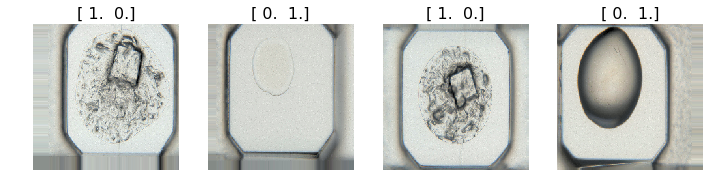

In [45]:
augmented_batches = augmented_gen.flow_from_directory(path + 'train', batch_size=batch_size, target_size=(224,224))
i = 0
ims, titles = next(augmented_batches)


# following code is for plotting the images
figsize = (12, 6)
rows = 1
interp = False
if type(ims[0]) is np.ndarray:
    ims = np.array(ims).astype(np.uint8)
    if (ims.shape[-1] != 3):
        ims = ims.transpose((0,2,3,1))
f = plt.figure(figsize=figsize)
for i in range(len(ims)):
    sp = f.add_subplot(rows, len(ims)//rows, i+1)
    sp.axis('Off')
    if titles is not None:
        sp.set_title(titles[i], fontsize=16)
    plt.imshow(ims[i], interpolation=None if interp else 'none')

[0, 1] ==> no crystal

[1, 0] ==> got crystal

can save the generated data so that it can be used as training data